# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

#FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [01:55<00:00, 518File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

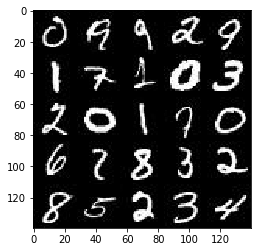

In [1]:

import helper
data_dir = './data'
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

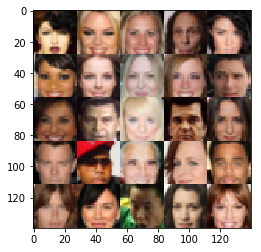

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32)
    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    keep_prob = 0.9
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x?
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
        # 14x14x64
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 7x7x128
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 14x14x128 now

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        #x4 = tf.nn.dropout(x4, keep_prob=keep_prob)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                 labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                       labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #from IPython.core.debugger import Tracer; Tracer()()
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    #from IPython.core.debugger import Tracer; Tracer()()

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    losses = []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.9932... Generator Loss: 0.0225
Epoch 1/2... Discriminator Loss: 1.5894... Generator Loss: 1.7382
Epoch 1/2... Discriminator Loss: 1.4864... Generator Loss: 2.7419
Epoch 1/2... Discriminator Loss: 2.3807... Generator Loss: 0.3258
Epoch 1/2... Discriminator Loss: 2.5706... Generator Loss: 0.2806
Epoch 1/2... Discriminator Loss: 3.6924... Generator Loss: 0.2068
Epoch 1/2... Discriminator Loss: 1.7756... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.4690... Generator Loss: 0.7864
Epoch 1/2... Discriminator Loss: 1.6564... Generator Loss: 0.6381
Epoch 1/2... Discriminator Loss: 1.7999... Generator Loss: 0.7286


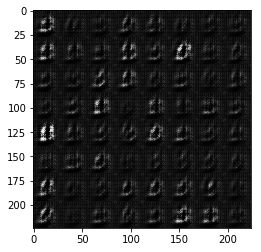

Epoch 1/2... Discriminator Loss: 1.5369... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 1.5018... Generator Loss: 0.7502
Epoch 1/2... Discriminator Loss: 1.4831... Generator Loss: 0.6587
Epoch 1/2... Discriminator Loss: 1.6393... Generator Loss: 0.5903
Epoch 1/2... Discriminator Loss: 1.3399... Generator Loss: 0.7707
Epoch 1/2... Discriminator Loss: 1.4822... Generator Loss: 0.7710
Epoch 1/2... Discriminator Loss: 1.7819... Generator Loss: 0.6111
Epoch 1/2... Discriminator Loss: 1.5269... Generator Loss: 0.9282
Epoch 1/2... Discriminator Loss: 1.4208... Generator Loss: 0.7297
Epoch 1/2... Discriminator Loss: 1.5106... Generator Loss: 0.7768


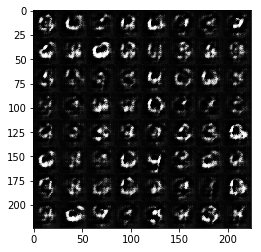

Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 0.8670
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 1.7902... Generator Loss: 0.8597
Epoch 1/2... Discriminator Loss: 1.5159... Generator Loss: 0.5406
Epoch 1/2... Discriminator Loss: 1.4356... Generator Loss: 0.8673
Epoch 1/2... Discriminator Loss: 1.4960... Generator Loss: 0.8281
Epoch 1/2... Discriminator Loss: 1.5226... Generator Loss: 0.9428
Epoch 1/2... Discriminator Loss: 1.4880... Generator Loss: 0.6131
Epoch 1/2... Discriminator Loss: 1.5165... Generator Loss: 0.7502
Epoch 1/2... Discriminator Loss: 1.5879... Generator Loss: 0.4654


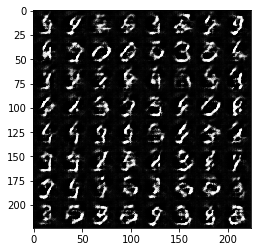

Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 0.8588
Epoch 1/2... Discriminator Loss: 1.4622... Generator Loss: 0.5761
Epoch 1/2... Discriminator Loss: 1.5225... Generator Loss: 0.8662
Epoch 1/2... Discriminator Loss: 1.6529... Generator Loss: 0.4336
Epoch 1/2... Discriminator Loss: 1.4490... Generator Loss: 0.8446
Epoch 1/2... Discriminator Loss: 1.4878... Generator Loss: 0.6835
Epoch 1/2... Discriminator Loss: 1.5274... Generator Loss: 0.5311
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 1.0389
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 0.7826
Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 0.7192


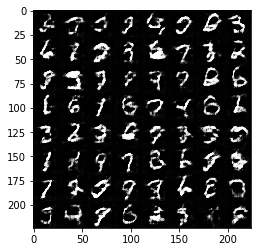

Epoch 1/2... Discriminator Loss: 1.4236... Generator Loss: 0.8819
Epoch 1/2... Discriminator Loss: 1.5309... Generator Loss: 1.2555
Epoch 1/2... Discriminator Loss: 1.4414... Generator Loss: 0.9168
Epoch 1/2... Discriminator Loss: 1.5115... Generator Loss: 0.7287
Epoch 1/2... Discriminator Loss: 1.4461... Generator Loss: 0.8804
Epoch 1/2... Discriminator Loss: 1.4758... Generator Loss: 0.8492
Epoch 1/2... Discriminator Loss: 1.3366... Generator Loss: 0.8284
Epoch 1/2... Discriminator Loss: 1.5451... Generator Loss: 0.4916
Epoch 1/2... Discriminator Loss: 1.5541... Generator Loss: 0.6183
Epoch 1/2... Discriminator Loss: 1.5037... Generator Loss: 0.7020


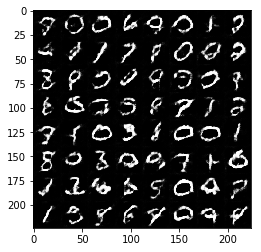

Epoch 1/2... Discriminator Loss: 1.4021... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 1.4752... Generator Loss: 1.0737
Epoch 1/2... Discriminator Loss: 1.4445... Generator Loss: 0.5890
Epoch 1/2... Discriminator Loss: 1.4231... Generator Loss: 0.6271
Epoch 1/2... Discriminator Loss: 1.4913... Generator Loss: 0.9613
Epoch 1/2... Discriminator Loss: 1.4677... Generator Loss: 0.9615
Epoch 1/2... Discriminator Loss: 1.4252... Generator Loss: 0.7219
Epoch 1/2... Discriminator Loss: 1.3777... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.4180... Generator Loss: 0.7653
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 0.8242


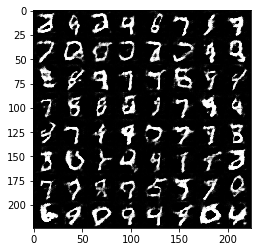

Epoch 1/2... Discriminator Loss: 1.5590... Generator Loss: 1.1743
Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 0.6434
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 1.5567... Generator Loss: 0.7203
Epoch 1/2... Discriminator Loss: 1.6330... Generator Loss: 0.4448
Epoch 1/2... Discriminator Loss: 1.3857... Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 1.4557... Generator Loss: 1.0329
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 0.8968
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.6596
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.6634


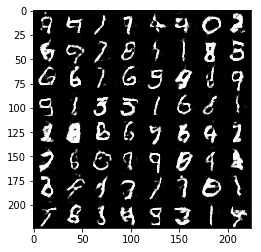

Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 0.6832
Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 0.8240
Epoch 1/2... Discriminator Loss: 1.4012... Generator Loss: 0.8145
Epoch 1/2... Discriminator Loss: 1.4831... Generator Loss: 0.6693
Epoch 1/2... Discriminator Loss: 1.6760... Generator Loss: 1.5470
Epoch 1/2... Discriminator Loss: 1.4413... Generator Loss: 0.6912
Epoch 1/2... Discriminator Loss: 1.4108... Generator Loss: 0.9080
Epoch 1/2... Discriminator Loss: 1.5102... Generator Loss: 0.4866
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.6688
Epoch 1/2... Discriminator Loss: 1.4772... Generator Loss: 0.6843


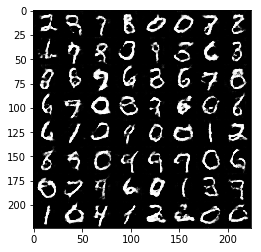

Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 0.8664
Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 1.4822... Generator Loss: 0.8995
Epoch 1/2... Discriminator Loss: 1.4317... Generator Loss: 0.8557
Epoch 1/2... Discriminator Loss: 1.8073... Generator Loss: 1.5051
Epoch 1/2... Discriminator Loss: 1.4310... Generator Loss: 0.7248
Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 0.6849
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.6919
Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 0.8444
Epoch 1/2... Discriminator Loss: 1.4661... Generator Loss: 0.9622


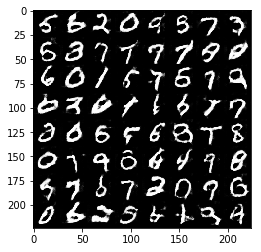

Epoch 1/2... Discriminator Loss: 1.4045... Generator Loss: 0.6801
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 0.8860
Epoch 1/2... Discriminator Loss: 1.9541... Generator Loss: 0.2727
Epoch 2/2... Discriminator Loss: 1.4292... Generator Loss: 0.6552
Epoch 2/2... Discriminator Loss: 1.4461... Generator Loss: 0.8248
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.7476
Epoch 2/2... Discriminator Loss: 1.4332... Generator Loss: 0.7130
Epoch 2/2... Discriminator Loss: 1.4895... Generator Loss: 0.5084
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.8570
Epoch 2/2... Discriminator Loss: 1.4125... Generator Loss: 0.7611


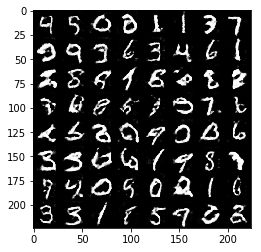

Epoch 2/2... Discriminator Loss: 1.3546... Generator Loss: 0.8949
Epoch 2/2... Discriminator Loss: 1.4320... Generator Loss: 0.9451
Epoch 2/2... Discriminator Loss: 1.3943... Generator Loss: 0.7429
Epoch 2/2... Discriminator Loss: 1.4112... Generator Loss: 0.8726
Epoch 2/2... Discriminator Loss: 1.4317... Generator Loss: 0.7343
Epoch 2/2... Discriminator Loss: 1.4819... Generator Loss: 0.9511
Epoch 2/2... Discriminator Loss: 1.2744... Generator Loss: 0.7306
Epoch 2/2... Discriminator Loss: 1.7229... Generator Loss: 1.2414
Epoch 2/2... Discriminator Loss: 1.4416... Generator Loss: 0.6608
Epoch 2/2... Discriminator Loss: 1.4085... Generator Loss: 0.7706


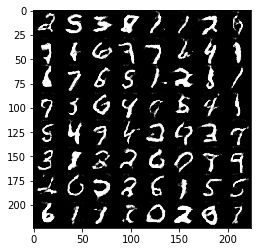

Epoch 2/2... Discriminator Loss: 1.4108... Generator Loss: 0.9319
Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 0.7877
Epoch 2/2... Discriminator Loss: 1.5039... Generator Loss: 0.8021
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.8574
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 0.6370
Epoch 2/2... Discriminator Loss: 1.3522... Generator Loss: 0.5635
Epoch 2/2... Discriminator Loss: 1.6252... Generator Loss: 1.4386
Epoch 2/2... Discriminator Loss: 1.3208... Generator Loss: 0.8217
Epoch 2/2... Discriminator Loss: 1.4743... Generator Loss: 0.5529
Epoch 2/2... Discriminator Loss: 1.4530... Generator Loss: 0.5964


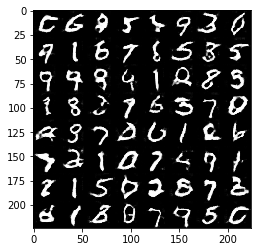

Epoch 2/2... Discriminator Loss: 1.3130... Generator Loss: 0.7639
Epoch 2/2... Discriminator Loss: 1.4184... Generator Loss: 0.6055
Epoch 2/2... Discriminator Loss: 1.4019... Generator Loss: 0.7817
Epoch 2/2... Discriminator Loss: 1.3631... Generator Loss: 0.7512
Epoch 2/2... Discriminator Loss: 1.3736... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 1.4727... Generator Loss: 0.4902
Epoch 2/2... Discriminator Loss: 1.4864... Generator Loss: 0.6605
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 0.9861
Epoch 2/2... Discriminator Loss: 1.3097... Generator Loss: 0.6768
Epoch 2/2... Discriminator Loss: 1.5256... Generator Loss: 1.2596


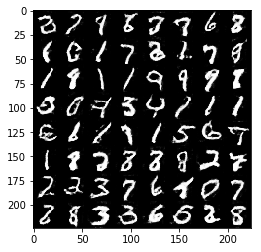

Epoch 2/2... Discriminator Loss: 1.4261... Generator Loss: 0.8432
Epoch 2/2... Discriminator Loss: 1.4547... Generator Loss: 0.8297
Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 1.4671... Generator Loss: 0.5944
Epoch 2/2... Discriminator Loss: 1.3975... Generator Loss: 0.8271
Epoch 2/2... Discriminator Loss: 1.4136... Generator Loss: 0.7459
Epoch 2/2... Discriminator Loss: 1.8018... Generator Loss: 0.3281
Epoch 2/2... Discriminator Loss: 1.4114... Generator Loss: 0.7130
Epoch 2/2... Discriminator Loss: 1.4063... Generator Loss: 0.5778
Epoch 2/2... Discriminator Loss: 1.5243... Generator Loss: 0.7893


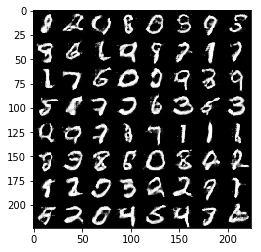

Epoch 2/2... Discriminator Loss: 1.3656... Generator Loss: 0.8017
Epoch 2/2... Discriminator Loss: 1.3778... Generator Loss: 0.8378
Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 0.9000
Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 0.8715
Epoch 2/2... Discriminator Loss: 1.4609... Generator Loss: 0.5140
Epoch 2/2... Discriminator Loss: 1.4342... Generator Loss: 0.5587
Epoch 2/2... Discriminator Loss: 1.4892... Generator Loss: 0.9554
Epoch 2/2... Discriminator Loss: 1.3923... Generator Loss: 0.7227
Epoch 2/2... Discriminator Loss: 1.3447... Generator Loss: 0.8066
Epoch 2/2... Discriminator Loss: 1.3141... Generator Loss: 0.7238


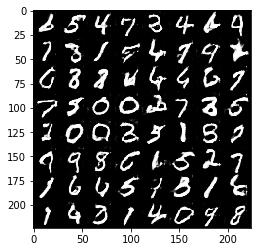

Epoch 2/2... Discriminator Loss: 1.5325... Generator Loss: 0.4811
Epoch 2/2... Discriminator Loss: 1.3952... Generator Loss: 0.6225
Epoch 2/2... Discriminator Loss: 1.6059... Generator Loss: 1.0514
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 1.1034
Epoch 2/2... Discriminator Loss: 1.4545... Generator Loss: 0.8838
Epoch 2/2... Discriminator Loss: 1.4342... Generator Loss: 0.6425
Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 0.9147
Epoch 2/2... Discriminator Loss: 1.4933... Generator Loss: 0.5603
Epoch 2/2... Discriminator Loss: 1.3698... Generator Loss: 0.7775
Epoch 2/2... Discriminator Loss: 1.3164... Generator Loss: 0.7053


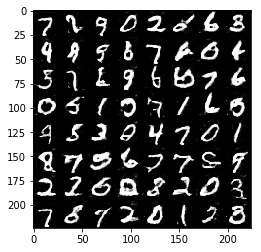

Epoch 2/2... Discriminator Loss: 1.4495... Generator Loss: 0.5689
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.7837
Epoch 2/2... Discriminator Loss: 1.3106... Generator Loss: 0.9934
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 1.4590... Generator Loss: 0.6715
Epoch 2/2... Discriminator Loss: 1.3561... Generator Loss: 0.7523
Epoch 2/2... Discriminator Loss: 1.2991... Generator Loss: 0.9232
Epoch 2/2... Discriminator Loss: 1.7454... Generator Loss: 0.3059
Epoch 2/2... Discriminator Loss: 1.4512... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.3609... Generator Loss: 0.8021


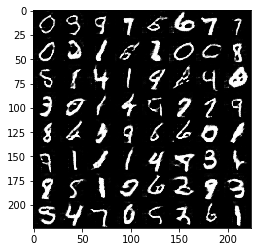

Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.7738
Epoch 2/2... Discriminator Loss: 1.6316... Generator Loss: 0.3610
Epoch 2/2... Discriminator Loss: 1.4325... Generator Loss: 0.7498
Epoch 2/2... Discriminator Loss: 1.4019... Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 1.4321... Generator Loss: 1.1143
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.9089
Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 0.9122
Epoch 2/2... Discriminator Loss: 1.3516... Generator Loss: 0.7446
Epoch 2/2... Discriminator Loss: 1.5108... Generator Loss: 1.3537
Epoch 2/2... Discriminator Loss: 1.4377... Generator Loss: 0.6028


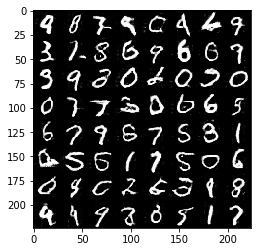

Epoch 2/2... Discriminator Loss: 1.4652... Generator Loss: 0.5948
Epoch 2/2... Discriminator Loss: 1.4039... Generator Loss: 0.7967
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.7152
Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.6630
Epoch 2/2... Discriminator Loss: 1.4585... Generator Loss: 0.8052
Epoch 2/2... Discriminator Loss: 1.3019... Generator Loss: 0.6489
Epoch 2/2... Discriminator Loss: 1.2959... Generator Loss: 0.9200


IndexError: list index out of range

In [11]:
batch_size = 64
z_dim = 100
learning_rate = 0.0007
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
#from IPython.core.debugger import Tracer; Tracer()()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 2.8057
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 1.0694
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 8.0154
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 3.0003
Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 3.8544
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 2.0274
Epoch 1/1... Discriminator Loss: 0.5310... Generator Loss: 3.2611
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 1.3894


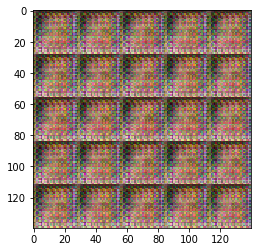

Epoch 1/1... Discriminator Loss: 0.6996... Generator Loss: 2.3445
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 3.0455
Epoch 1/1... Discriminator Loss: 0.6017... Generator Loss: 5.0505
Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 3.6251
Epoch 1/1... Discriminator Loss: 0.4612... Generator Loss: 3.0102
Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 2.6354
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 2.4461
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 2.6222
Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 2.2889
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 2.5298


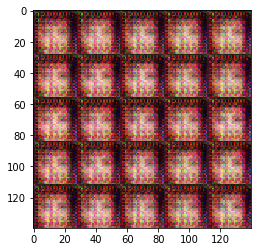

Epoch 1/1... Discriminator Loss: 0.5571... Generator Loss: 2.0366
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 2.8969
Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 2.0037
Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 1.5041
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.8003
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 3.2402
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 1.4762
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 1.2277
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 1.0262
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 1.1600


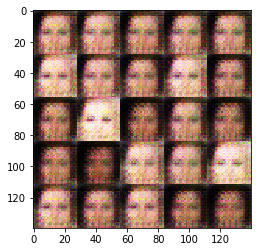

Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.6235
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 1.5790
Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.9994
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.7941
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 2.3599
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.3555
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 1.5460
Epoch 1/1... Discriminator Loss: 0.6902... Generator Loss: 1.7905


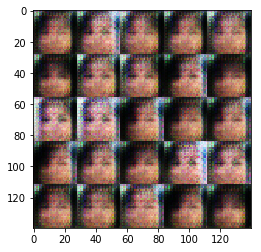

Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.3846
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.7717... Generator Loss: 0.4143
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.1073
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 2.8622
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 3.2691
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.7900


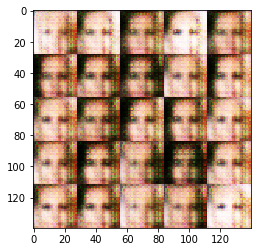

Epoch 1/1... Discriminator Loss: 0.6972... Generator Loss: 2.3924
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 2.2113... Generator Loss: 0.2535
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 1.2130
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 2.2181... Generator Loss: 0.2455
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 1.1674
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 2.4713
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.9294


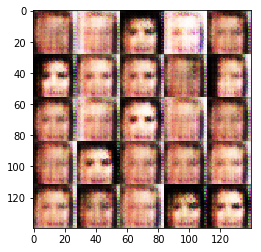

Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.6028
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.5291
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 2.5278
Epoch 1/1... Discriminator Loss: 0.7280... Generator Loss: 2.4075
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 1.1688
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.3294
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.4651


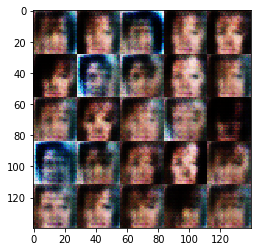

Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.4137
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.9422
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.4654
Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 1.6189
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 2.5894
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 2.0158
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 2.9019
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 1.7010


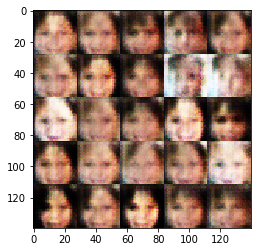

Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.2563
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.2249
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 0.9191... Generator Loss: 2.0927
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 1.1628
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 2.1687
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 1.7147
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.3718
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 1.4640


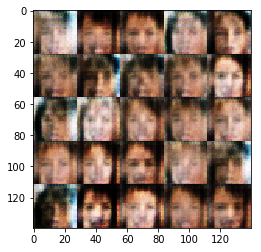

Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 1.7638
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 2.1544
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 1.0668
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.4760
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 1.6015
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.7992


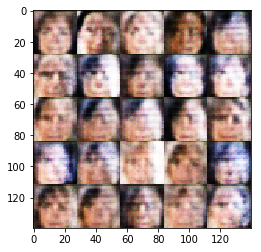

Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 1.4266
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 1.6052
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 1.0590


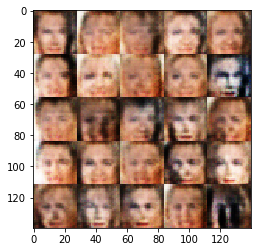

Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 2.2829
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 1.2054
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.4490
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 1.5647
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6476


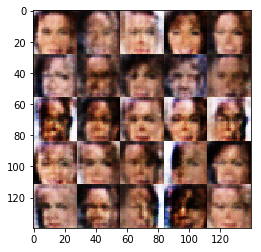

Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 1.4937
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.6856... Generator Loss: 0.3397
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 1.3003
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.9970
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.5395
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 1.0377
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 2.1848


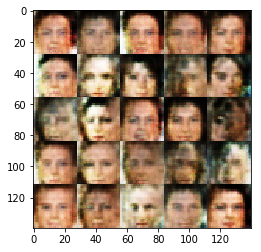

Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.7893... Generator Loss: 0.3134
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 1.0842
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.6994


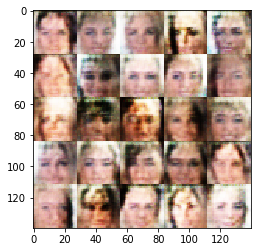

Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 1.2093
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.2251
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.5117


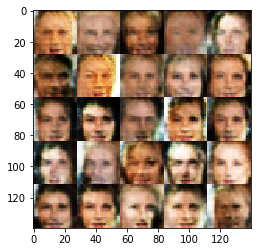

Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 1.2814
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 1.1730
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.4733
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 1.3854
Epoch 1/1... Discriminator Loss: 1.6582... Generator Loss: 0.3918
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.6268


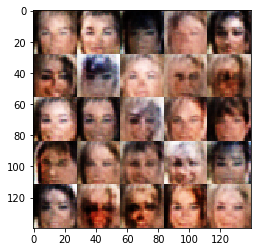

Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 1.2379
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 1.2885
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 1.0418
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 1.1465


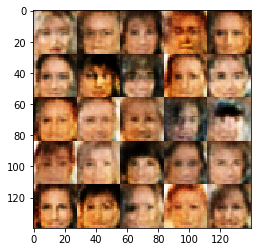

Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.3196
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 1.7638
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.9319


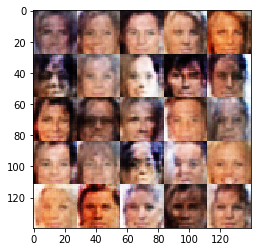

Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 1.2192
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.9740


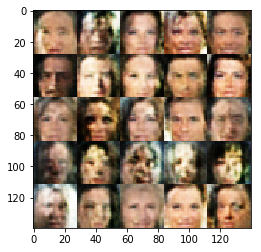

Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 1.1980
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 2.0025
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.5572


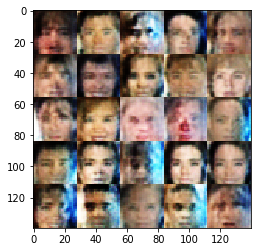

Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 1.1853


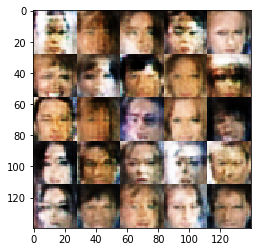

Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 1.2558
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 1.7644
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.6624


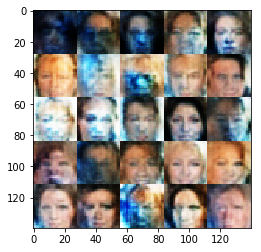

Epoch 1/1... Discriminator Loss: 1.7130... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 1.2563
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.4402
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 1.2568


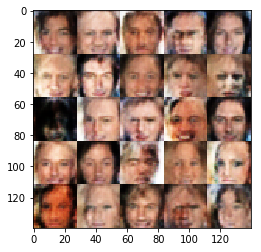

Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 1.1633
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 1.2310
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 1.4275


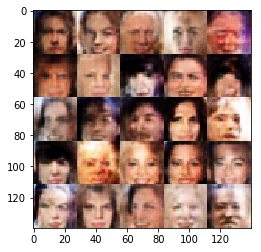

Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.7342


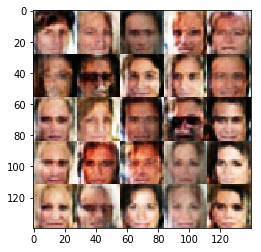

Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 1.2789
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 0.4440
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.3614
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.7328


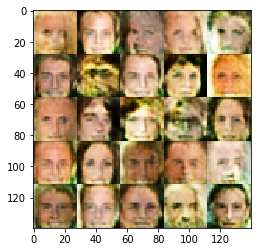

Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 1.4367
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 1.0719
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.6950


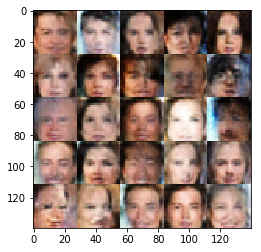

Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 1.1468
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 1.1918
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.7420


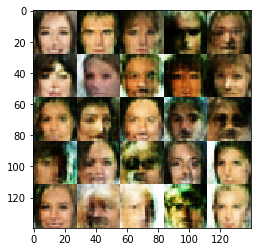

Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.4725


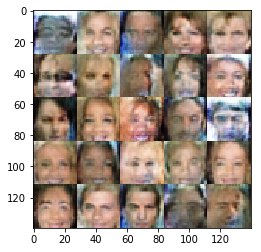

Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 1.1099
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.1830
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.4844


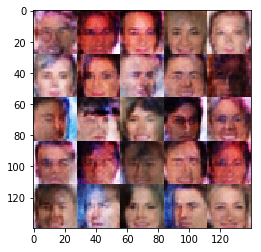

Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.5395
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 1.0304
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 1.0599
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.9545


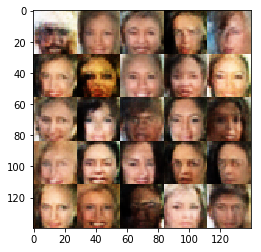

Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 1.1061
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.8865


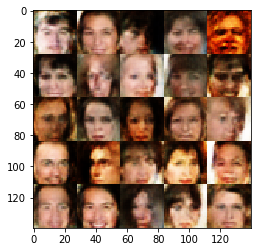

Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.4770
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8163


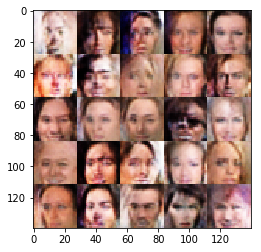

Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 1.1577
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.8310


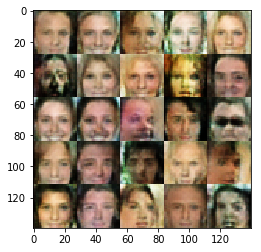

Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 1.0410
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.6446... Generator Loss: 0.4184
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.9967
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 1.3787
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 1.1527


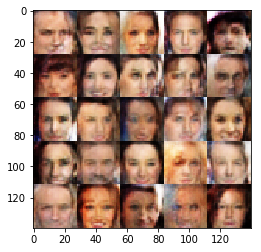

Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 1.2595
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 1.0196
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 1.0549
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 1.0813


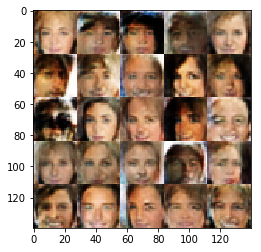

Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 1.0000


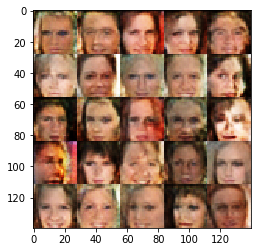

Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.5261
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6216


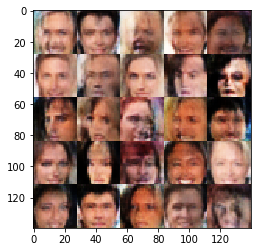

Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 1.0669
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 1.4218
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.8109


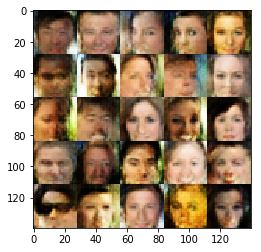

Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.5191
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.9013


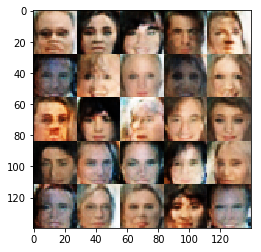

Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.0245
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6883


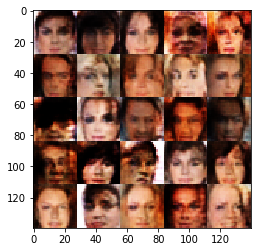

Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.5913... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 1.0805


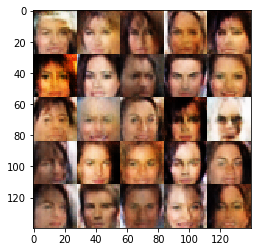

Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 1.1849
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.6554


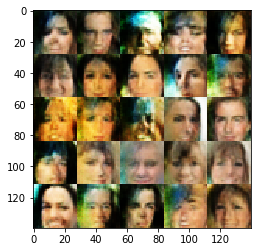

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.5865... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 1.0569
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.1611
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.6264


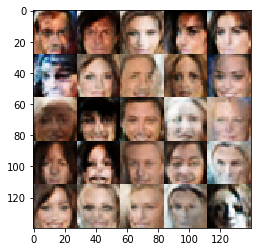

Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.6486... Generator Loss: 0.3721
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.9174


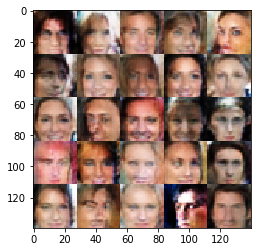

Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.5799


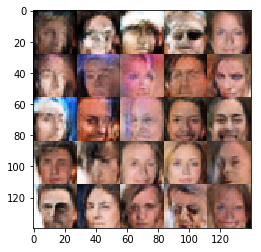

Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6689


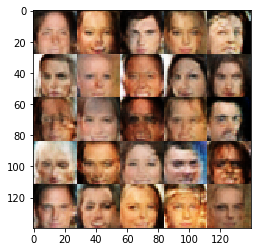

Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7643


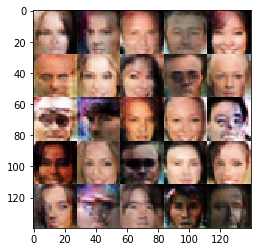

Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.4930


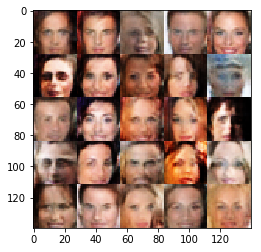

Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.8559


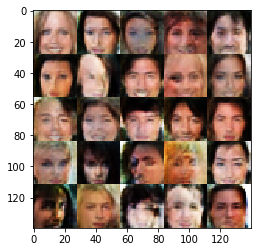

Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.4963


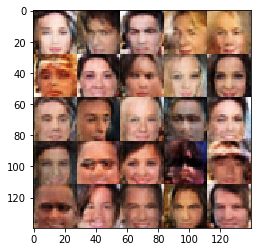

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 1.0569
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.8919


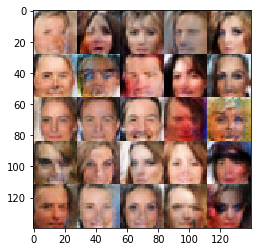

Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.8471


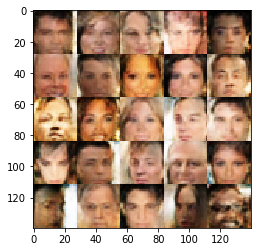

Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 1.2400
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.4499
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 1.2543
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 1.2476
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.6893


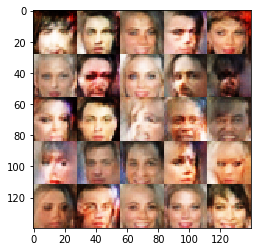

Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.3566
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.5342
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.9491


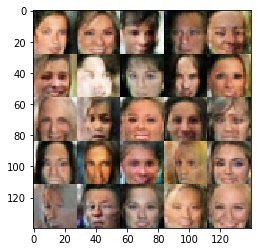

Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 1.1804
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 1.4185
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6918


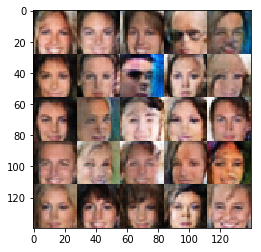

Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.8158


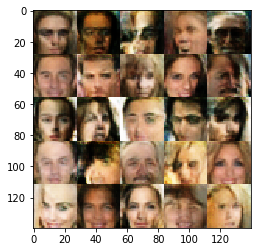

Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.4858
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 1.2690
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.7698


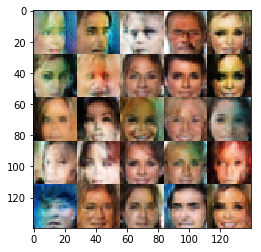

Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.7305


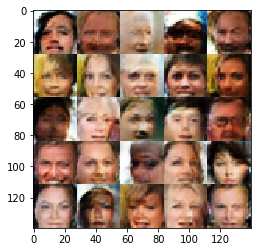

Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.7112


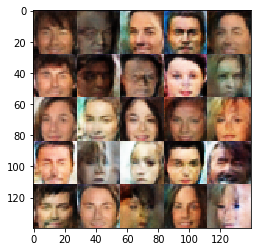

Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.0991
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.7420


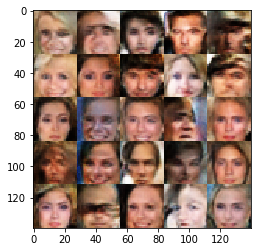

Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.8938


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.